In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [ ]:
!pip install simpletransformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 250.8/250.8 kB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 20.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.6/519.6 kB 32.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 5.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 55.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 46.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 85.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 70.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 37.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 30.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 38.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.6/190.6 kB 27.1 MB/s eta

In [ ]:
import re
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
from simpletransformers.classification import ClassificationModel, ClassificationArgs

In [ ]:
train_set = pd.read_csv("/content/gdrive/MyDrive/TamilNLP/train_ta_eng_ta_4480 - Sheet1.csv",header=None,sep=',')
validation_set = pd.read_csv("/content/gdrive/MyDrive/TamilNLP/Org_Dataset/ta-misogyny-dev.csv",header=None,sep='\t')
test_set = pd.read_csv("/content/gdrive/MyDrive/TamilNLP/Org_Dataset/tamil_test_with_labels.csv", header=None)
#prediction_set = pd.read_csv("/content/gdrive/MyDrive/TamilNLP/Org_Dataset/tamil_test_without_labels.csv", header=None)
print(f"Training data : {train_set.shape} \nValidation data : {validation_set.shape} \nTest data : {test_set.shape}")

Training data : (4480, 2) 
Validation data : (560, 2) 
Test data : (699, 2)


In [ ]:
def modify_dataset(df):
  df.rename(columns={0:'Label', 1:'Text'}, inplace=True)
  df = df[['Text', 'Label']]
  return df
train_set = modify_dataset(train_set)
validation_set = modify_dataset(validation_set)
test_set = modify_dataset(test_set)
#prediction_set = prediction_set.rename(columns={0:'Text'})

None-of-the-above    2592
Misandry              892
Counter-speech        298
Misogyny              250
Xenophobia            190
Hope-Speech           172
Homophobia             70
Transphobic            12
Not-Tamil               4
Name: Label, dtype: int64


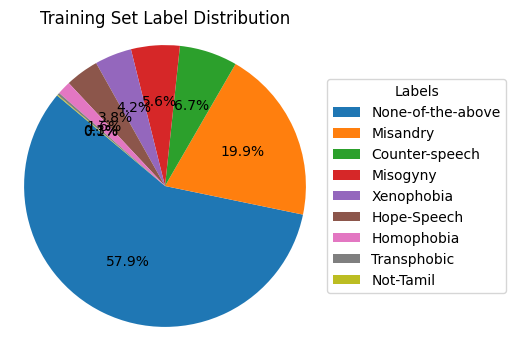

In [ ]:
category_counts = train_set['Label'].value_counts()
print(category_counts)
plt.figure(figsize=(4, 4))
wedges, labels, autopct = plt.pie(category_counts, autopct='%1.1f%%', startangle=140)
plt.legend(wedges, category_counts.index, title='Labels', loc='center left', bbox_to_anchor=(1, 0, 0.5, 1))
plt.title('Training Set Label Distribution')
plt.axis('equal')
plt.show()

In [ ]:
num_labels = len(train_set['Label'].unique())
keys = list(train_set['Label'].unique())
values = list(range(0, num_labels))
label_dict = dict(zip(keys,values))
train_set['Label'] = train_set['Label'].apply(lambda x:label_dict[x])
test_set['Label'] = test_set['Label'].apply(lambda x:label_dict[x])
validation_set['Label'] = validation_set['Label'].apply(lambda x:label_dict[x])
label_dict

{'Hope-Speech': 0,
 'None-of-the-above': 1,
 'Homophobia': 2,
 'Misandry': 3,
 'Counter-speech': 4,
 'Misogyny': 5,
 'Xenophobia': 6,
 'Transphobic': 7,
 'Not-Tamil': 8}

In [ ]:
def oversample(df):
    classes = df['Label'].value_counts().to_dict()
    most = max(classes.values())
    classes_list = []
    for key in classes:
        classes_list.append(df[df['Label'] == key])
    classes_sample = []
    for i in range(1,len(classes_list)):
        classes_sample.append(classes_list[i].sample(most, replace=True))
    df_maybe = pd.concat(classes_sample)
    final_df = pd.concat([df_maybe,classes_list[0]], axis=0)
    final_df = final_df.reset_index(drop=True)
    return pd.DataFrame({'Text': final_df['Text'].tolist(), 'Label': final_df['Label'].tolist()})
training_set = oversample(train_set)
training_set = training_set.sample(frac=1).reset_index(drop=True)

In [ ]:
epochs=3
model_args = ClassificationArgs()
model_args.overwrite_output_dir=True
model_args.eval_batch_size=8
model_args.train_batch_size=32
model_args.learning_rate=4e-5
model_args.save_model_every_epoch = True

In [ ]:
model = ClassificationModel(
    'bert',
    'google/muril-base-cased',
    num_labels=9,
    args=model_args,
    use_cuda=True,
    tokenizer_type="bert",
    tokenizer_name='google/muril-base-cased'
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google/muril-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
train_losses = []
train_accuracies = []

for i in range(epochs):
    model.train_model(training_set,eval_data=validation_set,acc=sklearn.metrics.classification_report)
    result, model_outputs, preds_list = model.eval_model(test_set,acc=sklearn.metrics.classification_report)
    #print(preds_list, model_outputs)
    for j in result.values():
        print(j)


/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:612: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/23328 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 0 of 1:   0%|          | 0/729 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:1454: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/699 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/88 [00:00<?, ?it/s]

0.37311763599914266
              precision    recall  f1-score   support

         0.0       0.25      0.58      0.34        26
         1.0       0.83      0.48      0.61       416
         2.0       0.60      0.75      0.67         8
         3.0       0.51      0.71      0.59       127
         4.0       0.19      0.60      0.29        47
         5.0       0.47      0.48      0.47        48
         6.0       0.41      0.28      0.33        25
         7.0       0.00      0.00      0.00         2

    accuracy                           0.53       699
   macro avg       0.41      0.48      0.41       699
weighted avg       0.66      0.53      0.55       699

1.4660432988947087


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/simpletransformers/class

  0%|          | 0/23328 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 0 of 1:   0%|          | 0/729 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:1454: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/699 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/88 [00:00<?, ?it/s]

0.45107450054962966
              precision    recall  f1-score   support

         0.0       0.35      0.50      0.41        26
         1.0       0.79      0.73      0.76       416
         2.0       0.60      0.75      0.67         8
         3.0       0.60      0.70      0.65       127
         4.0       0.28      0.38      0.32        47
         5.0       0.58      0.44      0.50        48
         6.0       0.56      0.36      0.44        25
         7.0       0.00      0.00      0.00         2

    accuracy                           0.66       699
   macro avg       0.47      0.48      0.47       699
weighted avg       0.68      0.66      0.66       699

1.1997721845453435


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/simpletransformers/class

  0%|          | 0/23328 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 0 of 1:   0%|          | 0/729 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:1454: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/699 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/88 [00:00<?, ?it/s]

0.4468113139269631
              precision    recall  f1-score   support

         0.0       0.36      0.46      0.41        26
         1.0       0.79      0.73      0.76       416
         2.0       0.67      0.75      0.71         8
         3.0       0.60      0.69      0.64       127
         4.0       0.27      0.40      0.32        47
         5.0       0.62      0.42      0.50        48
         6.0       0.48      0.40      0.43        25
         7.0       0.00      0.00      0.00         2

    accuracy                           0.66       699
   macro avg       0.47      0.48      0.47       699
weighted avg       0.68      0.66      0.66       699

1.6112803437493064


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
